In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression 

# set random state to use throughout
rs = 25

In [2]:
# import data and format it
data = pd.read_csv('../Data/gss_subset_cleaned.csv')
data = data[data['year']> 2005]
# drop highly correlated columns and unusable columns identified in earlier analysis
data.drop(['paeduc', 'maeduc', 'speduc', 'income', 'satjob', 'goodlife', 
           'health', 'year', 'hompop', 'earnrs'], axis=1, inplace=True)
# drop less important features from first run-through of RF
data.drop(['babies', 'preteen', 'teens', 'divorce', 'dwelling', 'sex', 'hhrace'], axis=1, inplace=True)

# check NA values
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13089 entries, 46510 to 59598
Data columns (total 11 columns):
marital     13073 non-null object
sibs        11549 non-null float64
childs      13059 non-null float64
age         13089 non-null float64
educ        13065 non-null float64
adults      13054 non-null float64
polviews    12562 non-null float64
happy       11534 non-null float64
weekswrk    11490 non-null float64
satfin      11533 non-null float64
dwelown     13066 non-null object
dtypes: float64(9), object(2)
memory usage: 1.2+ MB


In [3]:
print data['marital'].value_counts()
print data['dwelown'].value_counts()

married          6091
never_married    3377
divorced         2082
widowed          1083
separated         440
Name: marital, dtype: int64
other    5485
owns     4924
rents    2657
Name: dwelown, dtype: int64


In [4]:
# fill NA with mode for categorical
data1 = data.fillna({'marital': 'married', 'dwelown': 'other'})

# fill NA with median for numerical
data1 = data1.fillna(data1.drop('happy', axis=1).median())

# drop NA for happy
data1 = data1.dropna(subset=['happy'])

# check how many values remain
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11534 entries, 46510 to 59598
Data columns (total 11 columns):
marital     11534 non-null object
sibs        11534 non-null float64
childs      11534 non-null float64
age         11534 non-null float64
educ        11534 non-null float64
adults      11534 non-null float64
polviews    11534 non-null float64
happy       11534 non-null float64
weekswrk    11534 non-null float64
satfin      11534 non-null float64
dwelown     11534 non-null object
dtypes: float64(9), object(2)
memory usage: 1.1+ MB


In [5]:
# set X and y
X = pd.get_dummies(data1.drop('happy', axis=1), drop_first=True)
y = data1['happy'] == 1 # y is "true" when individual is unhappy

In [6]:
# look at % in each class
y.value_counts()/y.count()

False    0.857725
True     0.142275
Name: happy, dtype: float64

In [7]:
# do train_test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y,
        stratify = y, test_size=0.2, random_state=rs)

In [8]:
# instantiate Random Forest
rf = RandomForestClassifier(random_state=rs, n_jobs=-1)

In [9]:
# define param grid for gridsearch
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [15,18,21],
    'n_estimators': [15,18],
    'min_samples_split': [30,40,50],
    'min_samples_leaf': [5,10,20],
    'max_features': [5,10,'auto']
}

In [10]:
# instantiate gridsearch for random forest
gsrf = GridSearchCV(rf, param_grid, n_jobs=-1, scoring = 'roc_auc')

## Run and Evaluate Model on Fuller Training Set (including subjective features that would need to be assessed in interview)

In [11]:
# fit GS RF on training data, print best estimator and out-of-sample score
gsrf.fit(X1_train, y1_train)
print gsrf.best_estimator_
print gsrf.best_score_
print gsrf.score(X1_test, y1_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=30,
            min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)
0.745617289689
0.764501349536


/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [12]:
# Calculate prediction probabilities, use threshold of 15% to classify as unhappy
gsrf_proba1 = gsrf.predict_proba(X1_test)
gsrf_pred1 = gsrf_proba1[:,1] > 0.15
print classification_report(y1_test, gsrf_pred1)
print confusion_matrix(y1_test, gsrf_pred1)

             precision    recall  f1-score   support

      False       0.93      0.68      0.79      1979
       True       0.27      0.71      0.39       328

avg / total       0.84      0.69      0.73      2307

[[1350  629]
 [  95  233]]


In [13]:
# look at relative importance of different features
features = X1_train.columns
importances = gsrf.best_estimator_.feature_importances_
feat_importances = pd.DataFrame(index=features, columns = ['importance'])
feat_importances['importance'] = importances
feat_importances.sort_values(by='importance', ascending = False).round(decimals=3)

,importance
satfin,0.282
educ,0.128
age,0.108
marital_married,0.084
weekswrk,0.080
sibs,0.064
dwelown_owns,0.049
polviews,0.049
adults,0.048
childs,0.045


## Run and Evaluate Model on More Realistic Training Set (including only demographic/biographic information)

In [14]:
# drop subjective features
data2 = data.drop(['satfin', 'weekswrk', 'polviews'],axis=1)

# fill NA with mode for categorical
data2 = data2.fillna({'marital': 'married', 'dwelown': 'other'})

# fill NA with median for numerical
data2 = data2.fillna(data1.drop('happy', axis=1).median())

# drop NA for happy
data2 = data2.dropna(subset=['happy'])

# check how many values remain
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11534 entries, 46510 to 59598
Data columns (total 8 columns):
marital    11534 non-null object
sibs       11534 non-null float64
childs     11534 non-null float64
age        11534 non-null float64
educ       11534 non-null float64
adults     11534 non-null float64
happy      11534 non-null float64
dwelown    11534 non-null object
dtypes: float64(6), object(2)
memory usage: 811.0+ KB


In [15]:
# save this dataset for use in other models
data2.to_csv('../Data/gss_subset_for_modeling.csv', index=False, encoding='utf-8')

In [16]:
# set X and y
X = pd.get_dummies(data2.drop('happy', axis=1), drop_first=True)
y = data2['happy'] == 1 # y is "true" when individual is unhappy

In [17]:
# do train_test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y,
        stratify = y, test_size=0.2, random_state=rs)

In [18]:
# fit GS RF and print best estimator, out-of-sample score
gsrf.fit(X2_train, y2_train)
print gsrf.best_estimator_
print gsrf.best_score_
print gsrf.score(X2_test, y2_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=18, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)
0.683633313886
0.701330432961


In [19]:
# Calculate prediction probabilities, use threshold of 15% to classify as unhappy
gsrf_proba2 = gsrf.predict_proba(X2_test)
gsrf_pred2 = gsrf_proba2[:,1] > 0.15
print classification_report(y2_test, gsrf_pred2)
print confusion_matrix(y2_test, gsrf_pred2)

             precision    recall  f1-score   support

      False       0.92      0.63      0.75      1979
       True       0.23      0.66      0.34       328

avg / total       0.82      0.64      0.69      2307

[[1251  728]
 [ 111  217]]


In [20]:
# look at relative importance of different features
features = X2_train.columns
importances = gsrf.best_estimator_.feature_importances_
feat_importances = pd.DataFrame(index=features, columns = ['importance'])
feat_importances['importance'] = importances
feat_importances.sort_values(by='importance', ascending = False).round(decimals=3)

,importance
educ,0.225
age,0.192
marital_married,0.173
sibs,0.107
childs,0.081
dwelown_owns,0.074
adults,0.061
dwelown_rents,0.039
marital_never_married,0.022
marital_separated,0.015


## Compare with Logistic Regression

In [21]:
# instantiate logistic regression and gridsearch
lg = LogisticRegression(random_state = rs, n_jobs=-1)
C_range = 10.**np.arange(-2, 3)
param_grid = {'C':C_range, 'penalty': ['l1', 'l2']}
lggrid = GridSearchCV(lg, param_grid, scoring='roc_auc', verbose = 1, n_jobs=-1)

In [22]:
lggrid.fit(X2_train, y2_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=25, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [23]:
# print best parameters and score, as well as out of sample score
print lggrid.best_estimator_
print lggrid.best_score_
print lggrid.score(X2_test, y2_test)

LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=25,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.683738765914
0.71092122777


In [24]:
# Calculate prediction probabilities, use threshold of 15% to classify as unhappy
lggrid_proba = lggrid.predict_proba(X2_test)
lggrid_pred = lggrid_proba[:,1] > 0.15
print classification_report(y2_test, lggrid_pred)
print confusion_matrix(y2_test, lggrid_pred)

             precision    recall  f1-score   support

      False       0.92      0.64      0.76      1979
       True       0.24      0.68      0.35       328

avg / total       0.83      0.65      0.70      2307

[[1272  707]
 [ 105  223]]


## Look at ROC curves and Model Value-Add

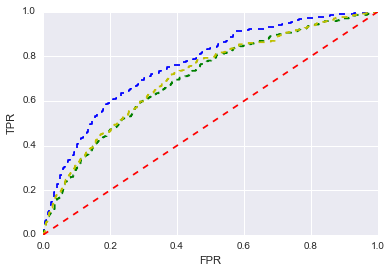

In [26]:
# look at ROC curve for RF models and LG model
fpr1, tpr1, _ = metrics.roc_curve(y1_test, gsrf_proba1[:,1])
fpr2, tpr2, _ = metrics.roc_curve(y2_test, gsrf_proba2[:,1])
lgfpr, lgtpr, _ = metrics.roc_curve(y2_test, lggrid_proba[:,1])
plt.plot(fpr1, tpr1, 'b--', fpr2, tpr2, 'g--', lgfpr, lgtpr, 'y--',fpr1, fpr1, 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [27]:
# save data as CSV for graphing in Tableau
df1 = pd.DataFrame({'Model': "RF more features", 'FPR': fpr1, 'TPR': tpr1})
df2 = pd.DataFrame({'Model': "RF non-subjective features", 'FPR': fpr2, 'TPR': tpr2})
df3 = pd.DataFrame({'Model': "Logistic Regression", 'FPR': lgfpr, 'TPR': lgtpr})
df4 = pd.DataFrame({'Model': 'Baseline', 'FPR': fpr1, 'TPR': fpr1})
df = df1.append(df2, ignore_index=True).append(df3, ignore_index=True).append(df4, ignore_index=True)
df = df[['Model', 'FPR', 'TPR']]
df.to_csv('../Data/rf_fpr_tpr.csv', encoding='utf-8', index=False)

In [28]:
def getPlotValueAdd(probas, y_test):
    # create dataframe with the model's predicted P(unhappy) along with boolean for actual unhappiness
    modelprobs = pd.DataFrame()
    modelprobs['Model_Prob_Unhappy'] = probas[:,1]
    modelprobs['Unhappy_True'] = y_test.as_matrix()

    # sort by P(Unhappy) and add columns for % Unhappy and % Happy people falling above that threshold
    modelprobs.sort_values(by='Model_Prob_Unhappy', axis=0, inplace=True, ascending=False)
    modelprobs['portion_unhappy_captured'] = np.cumsum(modelprobs['Unhappy_True'])/np.sum(modelprobs['Unhappy_True'])
    modelprobs['portion_happy_mislabeled'] = np.cumsum(1-modelprobs['Unhappy_True'])/np.sum(1-modelprobs['Unhappy_True'])
    # add column with ratio of correct prediction (ie, precision for predicting unhappiness)
    modelprobs['ratio_correct_prediction'] = np.cumsum(modelprobs['Unhappy_True'])/(np.cumsum(modelprobs['Unhappy_True']) + np.cumsum(1-modelprobs['Unhappy_True']))

    # Plot the difference
    x = modelprobs['Model_Prob_Unhappy']
    y1 = modelprobs['portion_unhappy_captured']
    y2 = modelprobs['portion_happy_mislabeled']
    y3 = modelprobs['ratio_correct_prediction']
    plt.plot(x, y1, 'b--', x, y2, 'r--', x, y3, 'g--')
    
    # return DF
    return modelprobs

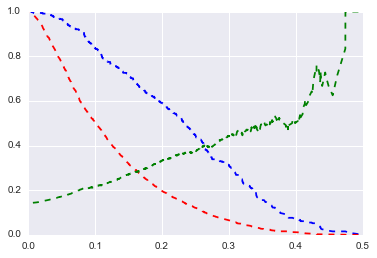

In [29]:
# look at value add for model with more features
modelprobs1 = getPlotValueAdd(gsrf_proba1, y1_test)

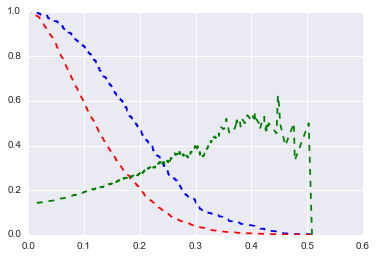

In [30]:
# look at value add for 'more realistic' model
modelprobs2 = getPlotValueAdd(gsrf_proba2, y2_test)

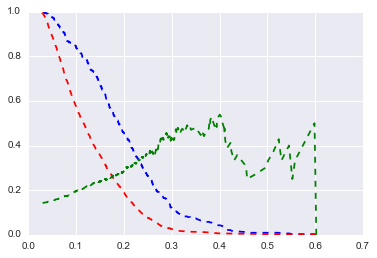

In [31]:
# look at value add for logistic regression model
modelprobsLG = getPlotValueAdd(lggrid_proba, y2_test)

## Save Data for Plotting in Tableau

In [34]:
melted = pd.melt(modelprobsLG, id_vars= ['Model_Prob_Unhappy', 'Unhappy_True'])

In [35]:
melted.to_csv('../Data/rf_proba_test.csv', index=False, encoding='utf-8')